In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import squarify

In [3]:
ecom_retail = pd.read_excel('ecommerce retail.xlsx', sheet_name='ecommerce retail')
ecom_retail.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [4]:
score_map = pd.read_excel('ecommerce retail.xlsx', sheet_name='Segmentation')
score_map

,Segment,RFM Score
0,Champions,"555, 554, 544, 545, 454, 455, 445"
1,Loyal,"543, 444, 435, 355, 354, 345, 344, 335"
2,Potential Loyalist,"553, 551, 552, 541, 542, 533, 532, 531, 452, 4..."
3,New Customers,"512, 511, 422, 421, 412, 411, 311"
4,Promising,"525, 524, 523, 522, 521, 515, 514, 513, 425,42..."
5,Need Attention,"535, 534, 443, 434, 343, 334, 325, 324"
6,About To Sleep,"331, 321, 312, 221, 213, 231, 241, 251"
7,At Risk,"255, 254, 245, 244, 253, 252, 243, 242, 235, 2..."
8,Cannot Lose Them,"155, 154, 144, 214,215,115, 114, 113"
9,Hibernating customers,"332, 322, 233, 232, 223, 222, 132, 123, 122, 2..."


# I. Explore Data

### 1. Check Missing values & Data type

In [5]:
ecom_retail.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


- Missing Value: 
    + Col Description: ignore
    + Col CustomerID: delete the missing CustomerID rows since the analysis is customer specific, missing data gives no information.
- Inappropriate Data Type:
    + Col CustomerID (float64) -> str

In [6]:
# Remove missing CustomerID rows
ecom_retail = ecom_retail[ecom_retail['CustomerID'].notnull()]
ecom_retail.reset_index(drop=True, inplace=True)

In [7]:
# Change CustomerID data type to String
ecom_retail['CustomerID'] = ecom_retail['CustomerID'].astype('int')
ecom_retail['CustomerID'] = ecom_retail['CustomerID'].astype('str')

### 2. Identify Duplicates

In [8]:
# Checking duplicate
duplicated_rows = ecom_retail[ecom_retail.duplicated]
duplicated_rows.shape

(5225, 8)

In [9]:
# Drop duplicated rows
ecom_retail.drop_duplicates(inplace=True)
ecom_retail.reset_index(drop=True, inplace=True)
ecom_retail.shape

(401604, 8)

### 3. Get summary statistic

In [10]:
ecom_retail.describe()

,Quantity,InvoiceDate,UnitPrice
count,401604.000000,401604,401604.000000
mean,12.183273,2011-07-10 12:08:23.848567552,3.474064
min,-80995.000000,2010-12-01 08:26:00,0.000000
25%,2.000000,2011-04-06 15:02:00,1.250000
50%,5.000000,2011-07-29 15:40:00,1.950000
75%,12.000000,2011-10-20 11:58:30,3.750000
max,80995.000000,2011-12-09 12:50:00,38970.000000
std,250.283037,NaN,69.764035


- Quantity has negative values (refunds) -> exclude
- UnitPrice has 0 value -> exclude due to 0 value in UnitPrice generate no income.

In [11]:
# Select only rows which InvoiceNo not start with C and UnitPrice > 0
ecom_retail = ecom_retail[(~ecom_retail['InvoiceNo'].str.startswith('C', na=False)) & (ecom_retail['UnitPrice'] > 0) ]

In [12]:
ecom_retail.describe()
ecom_retail.shape

(392692, 8)

# II. RFM Model

### 1. Calculare RFM

In [13]:
# Assign snapshot_date to calculate Recency
snapshot_date = pd.to_datetime('2011/12/31')

In [14]:
# Calculate Total Invoice Amount
ecom_retail['TotalSum'] = ecom_retail['Quantity'] * ecom_retail['UnitPrice']

# Calculate Recency, Frequency and Monetary value for each customer 
RFM_table = ecom_retail.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days, 
    'InvoiceNo': 'nunique', 
    'TotalSum': 'sum'}).reset_index()

# Rename the columns
RFM_table.rename(columns={
    'InvoiceDate': 'Recency',
    'InvoiceNo': 'Frequency',
    'TotalSum': 'Monetary'}, inplace=True)
RFM_table

,CustomerID,Recency,Frequency,Monetary
0,12346,346,1,77183.60
1,12347,23,7,4310.00
2,12348,96,4,1797.24
3,12349,39,1,1757.55
4,12350,331,1,334.40
...,...,...,...,...
4333,18280,298,1,180.60
4334,18281,201,1,80.82
4335,18282,28,2,178.05
4336,18283,24,16,2045.53


### 2. Compute Quantile of RFM values

In [15]:
# Create labels for Recency
r_labels = range(5, 0, -1)
# Create labels for Frequency and Monytary
f_labels = m_labels = range(1, 6)

# Assign RFM score
r_quartiles = pd.qcut(RFM_table['Recency'], q=5, labels=r_labels)
f_quartiles = pd.qcut(RFM_table['Frequency'].rank(method='first'), q=5, labels=f_labels)
m_quartiles = pd.qcut(RFM_table['Monetary'], q=5, labels=m_labels)

RFM_table = RFM_table.assign(R = r_quartiles.values, F = f_quartiles.values, M = m_quartiles.values)
RFM_table

,CustomerID,Recency,Frequency,Monetary,R,F,M
0,12346,346,1,77183.60,1,1,5
1,12347,23,7,4310.00,5,5,5
2,12348,96,4,1797.24,2,4,4
3,12349,39,1,1757.55,4,1,4
4,12350,331,1,334.40,1,1,2
...,...,...,...,...,...,...,...
4333,18280,298,1,180.60,1,2,1
4334,18281,201,1,80.82,1,2,1
4335,18282,28,2,178.05,5,3,1
4336,18283,24,16,2045.53,5,5,4


In [16]:
# Combine RFM Score
def join_rfm(x): return str(x['R']) + str(x['F']) + str(x['M'])
RFM_table['RFM_Segment'] = RFM_table.apply(join_rfm, axis=1)

### 3. Join with score_map table

#### a. Transform score_map table

In [17]:
# Split by string and trim whitespace
score_map['RFM Score'] = score_map['RFM Score'].str.split(',').map(lambda items: [i.strip() for i in items])

# Convert column into rows
score_map = score_map.explode('RFM Score').reset_index(drop=True)

#### b. Merge on RFM Score

In [18]:
Segment = pd.merge(RFM_table, score_map, how='left', left_on='RFM_Segment', right_on='RFM Score').drop(columns='RFM Score')
Segment.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4338 entries, 0 to 4337
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   CustomerID   4338 non-null   object  
 1   Recency      4338 non-null   int64   
 2   Frequency    4338 non-null   int64   
 3   Monetary     4338 non-null   float64 
 4   R            4338 non-null   category
 5   F            4338 non-null   category
 6   M            4338 non-null   category
 7   RFM_Segment  4338 non-null   object  
 8   Segment      4338 non-null   object  
dtypes: category(3), float64(1), int64(2), object(3)
memory usage: 216.6+ KB


# III. Visualization

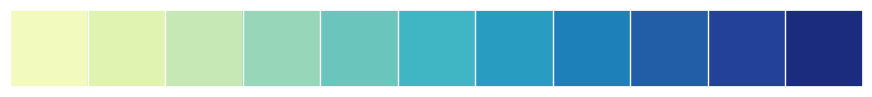

In [19]:
sns.set_theme()
# sns.color_palette("coolwarm", 11)
sns.palplot(sns.color_palette("YlGnBu", 11))

### 1. Distribution of R, F, M

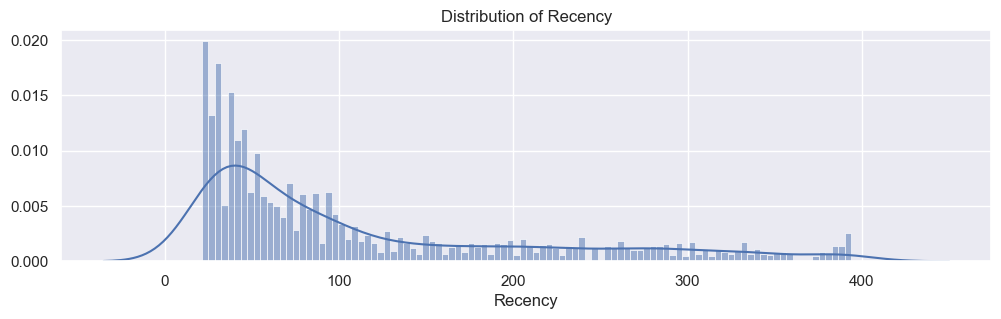

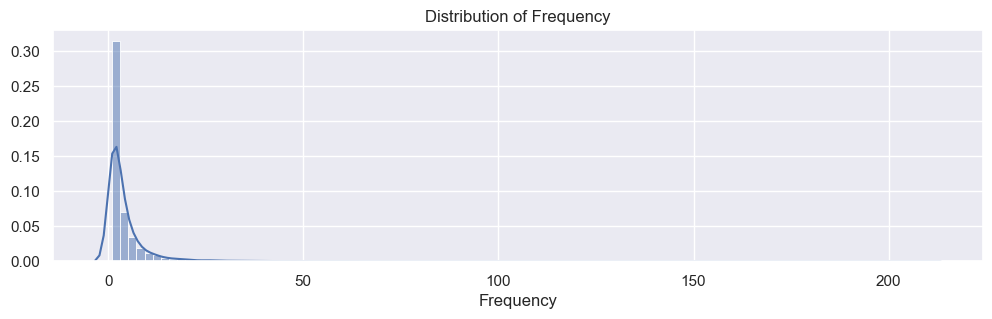

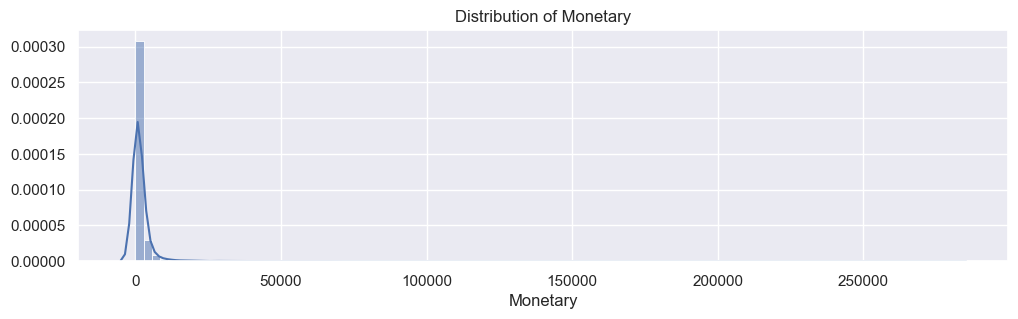

In [20]:
colnames = ['Recency', 'Frequency', 'Monetary']
# distplot in subplot is depreciated, replace by histplot
for col in colnames:
    fig, ax = plt.subplots(figsize=(12, 3))
    sns.histplot(data=Segment, 
                 x=col,
                 kde=True, 
                 stat='density', 
                 kde_kws=dict(cut=3),        
                 bins=100)
    ax.set(ylabel='', title='Distribution of %s' % col)
    plt.show()

<Axes: xlabel='Monetary', ylabel='Count'>

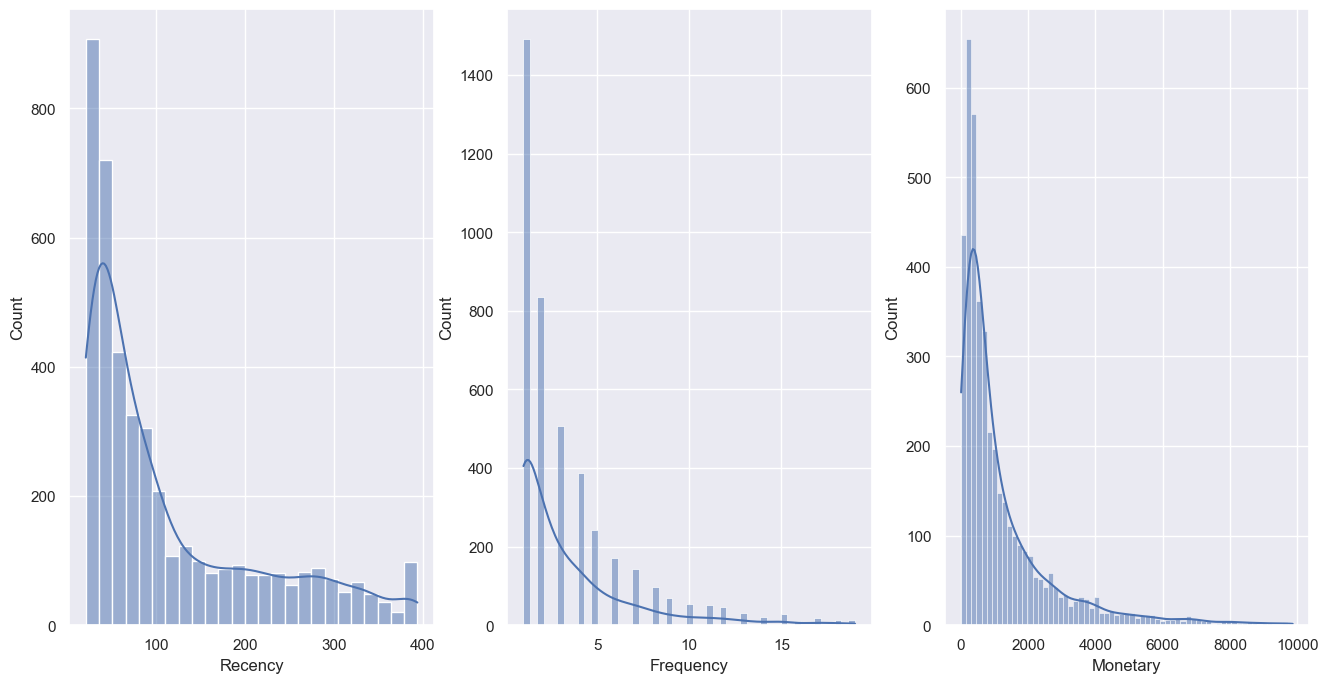

In [35]:
# Zoom in
fig, ax = plt.subplots(1, 3, figsize=(16, 8))

# Recency distribution plot
sns.histplot(Segment['Recency'], kde=True, ax=ax[0])

# Frequency distribution plot
sns.histplot(Segment.query('Frequency < 20')['Frequency'], kde=True, ax=ax[1])

# Monetary distribution plot
sns.histplot(Segment.query('Monetary < 10000')['Monetary'], kde=True, ax=ax[2])

As we see in the graph all Recency, Frequency and Monetary values are on different scales and ranges, and all three indicators are right-skewed.
- For Recency, it show that the majority of customers made a purchase in the recent past.
- For Frequency, most part of customer has low frequency (small number of orders, 1-2 orders) 
- For Monetary, most of customers have only spent little amount of money

In [21]:
# Frequency
Segment['Frequency'].value_counts(normalize=True).mul(100).round(1).astype(str).head() + '%'

Frequency
1    34.4%
2    19.2%
3    11.7%
4     8.9%
5     5.6%
Name: proportion, dtype: object

### 2. Segment by Customers and Total sales

#### a. Transform data

In [22]:
# Count Number of Customer and Total Sales in each Segment
stas_segment = Segment.groupby('Segment').agg(
    NumCust=('CustomerID', 'nunique'), 
    TotalSales=('Monetary', 'sum')).reset_index()

# Display in percent
stas_segment['%NumCust'] = (stas_segment['NumCust']/stas_segment['NumCust'].sum())*100
stas_segment['%TotalSales'] = (stas_segment['TotalSales']/stas_segment['TotalSales'].sum())*100

stas_segment

,Segment,NumCust,TotalSales,%NumCust,%TotalSales
0,About To Sleep,286,78743.090,6.592900,0.886027
1,At Risk,423,750634.391,9.751037,8.446233
2,Cannot Lose Them,92,204036.680,2.120793,2.295847
3,Champions,834,5591628.710,19.225450,62.917714
4,Hibernating customers,693,282751.372,15.975104,3.181554
5,Lost customers,485,96590.980,11.180267,1.086854
6,Loyal,426,1015451.640,9.820194,11.425990
7,Need Attention,287,467188.591,6.615952,5.256865
8,New Customers,268,59674.930,6.177962,0.671470
9,Potential Loyalist,411,221408.990,9.474412,2.491322


#### b. Segment by Customers and Total sales

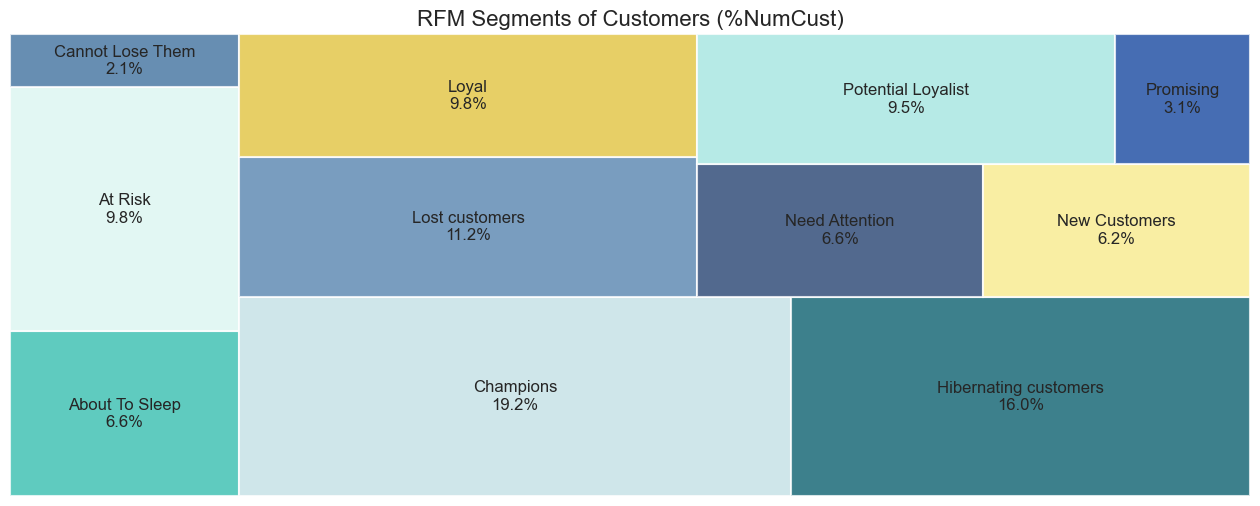

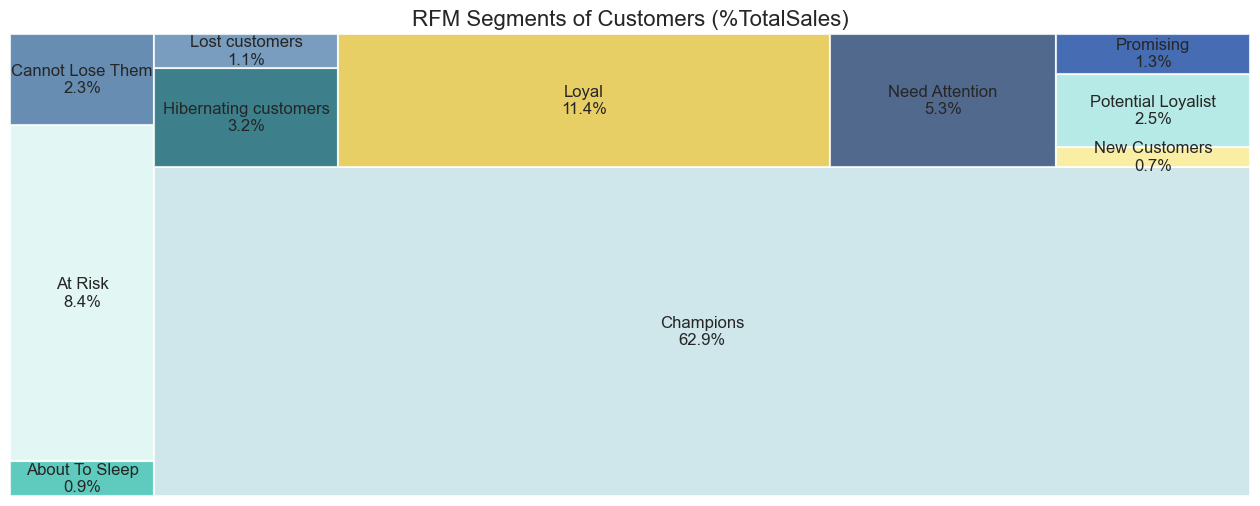

In [23]:
colors = ['#37BEB0', '#DBF5F0', '#41729F', '#C3E0E5', '#0C6170', '#5885AF', '#E1C340', '#274472', '#F8EA8C', '#A4E5E0', '#1848A0']

for col in ['%NumCust', '%TotalSales']:
    labels = stas_segment['Segment'] + '\n' + stas_segment[col].apply(lambda x:f'{x:.1f}%')

    fig, ax = plt.subplots(figsize=(16,6))
    squarify.plot(sizes=stas_segment[col], label=labels, alpha=.8, 
                  color=colors, 
                  text_kwargs={'wrap':True}, bar_kwargs=dict(linewidth=1.5, edgecolor='white'))
    ax.set_title('RFM Segments of Customers (%s)' % col, fontsize=16)
    plt.axis('off')
    plt.show()